<h1>Mini Project 2: Breast Cancer Wisonsin</h1>
<h4>By Patrick Chesnut</h4>
<span>GitHub: </span><a style="color:CornflowerBlue"><u>https://github.com/cu-cspb-4622-spring-2024/P2-chesnutpc</u></a>

In [62]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings as wr
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
wr.filterwarnings('ignore')

<h3>Project Topic</h3>
This project explores the application of Principal Component Analysis (PCA) and K-means clustering to a dataset derived from fine needle aspirations of breast nodules. The dataset comprises various feature variables that describe the characteristics of cell nuclei present in the digital images of the fine needle aspirate (FNA) of a breast mass. These features include measurements that reflect the size, shape, and texture of the cell nuclei, among others. Our target variable categorizes the nodule as either benign (non-cancerous) or malignant (cancerous), making this essentially a <b>classification</b> problem. However, rather than approaching it directly as such, this project seeks to employ a two-stage unsupervised learning strategy. Initially, PCA is applied to reduce the dimensionality of the dataset, highlighting the most significant features while minimizing information loss. Subsequently, the K-means clustering algorithm is utilized to group the specimens into clusters, aiming to distinguish between benign and malignant tumors based on the transformed features.<br><br>

In summary, this project is an exploration of unsupervised learning techniques, specifically PCA and K-means clustering, applied to a breast cancer dataset. The goal is to uncover patterns and potential classifications within the data that could aid in understanding the nature of breast tumors, thereby contributing to the improvement of diagnostic methods and treatments. Through this analysis, the project emphasizes the value of machine learning and data science in general and will give me exposure to these topics.





<h3>Data</h3>
The data for this project was obtained from the UC-Irvine Machine Learning Repository, a link is provided below:<br>
<a style="color:CornflowerBlue"><u>https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic</u></a>
<br><br>

The complete dataset can be downloaded as a 122kB csv file.  There is also a text file available that contains some basic information.  The dataset consists of 569 observations, each representing a different fine needle aspiration.  There are 30 features (not including a unique Id number) and the target variable.  All are briefly described below:
<ol>
    <li>Id: Numerical, random number for each specimen</li>
    <li>Diagnosis: Categorical, metastatic or benign nodule</li>
    Mean, standard error and worst values are given for each of the 10 features below:
    <li>Radius: Numerical, mean of distances from center of cell to perimeter</li>
    <li>Texture: Numerical, standard deviation of grey scale values</li>
    <li>Perimeter: Numerical, cell perimeter</li>
    <li>Area: Numerical, cell area</li>
    <li>Smoothness: Numerical, local variation in radius lengths</li>
    <li>Compactness: Numerical, roughly perimeter squared divided by area</li>
    <li>Concavity: Numerical, severity of concave portions of the contour</li>
    <li>Concave Points: Numerical, number of concave portions</li>
    <li>Symmetry: Numerical, cell symmetry</li>
    <li>Fractal: Numerical, coastline approximation</li>
</ol>

There are no missing values.

<h3>Data Cleaning and EDA</h3>

Before getting to model building, I prepare and explore the dataset to ensure its readiness for model building. This section outlines the process of data cleaning and exploratory data analysis. The first step is to load the data from the csv file.  The file does not contain a header so each column needs to be named manually.  I will create three dataframes: df contains all of the data except for Id which will be dropped as it contains no information for models to build on, X will contain all of the features, and y will contain diagnosis (the target variable).  Following loading the data, I run the info method to get datatypes and counts of observations.  This is followed by the tail method to insure that the data is as expected.


In [19]:
# Load data
df = pd.read_csv('data/wdbc.data', header=None,
                 names=['Id','Diagnosis','Radius_mean','Texture_mean',
                        'Perimeter_mean','Area_mean','Smoothness_mean',
                        'Compactness_mean','Concavity_mean',
                        'Concave_pts_mean', 'Symmetry_mean','Fractal_mean',
                        'Radius_se','Texture_se',
                        'Perimeter_se','Area_se','Smoothness_se',
                        'Compactness_se','Concavity_se',
                        'Concave_pts_se', 'Symmetry_se','Fractal_se',
                        'Radius_worst','Texture_worst',
                        'Perimeter_worst','Area_worst','Smoothness_worst',
                        'Compactness_worst','Concavity_worst',
                        'Concave_pts_worst', 'Symmetry_worst','Fractal_worst',])


# Convert diagnosis feature to binary, 1=metastatic, 0=benign
df['Diagnosis'] = df['Diagnosis'].apply(lambda x: 1 if x == 'M' else 0)

# Drop the Id column
df.drop(columns=['Id'], inplace=True)

# Let X be the data without the diagnosis
X = df.drop(columns=['Diagnosis'])

# Ley y be the diagnoses
y = df['Diagnosis']

print(X.info())
print(X.tail())
print(y.tail())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Radius_mean        569 non-null    float64
 1   Texture_mean       569 non-null    float64
 2   Perimeter_mean     569 non-null    float64
 3   Area_mean          569 non-null    float64
 4   Smoothness_mean    569 non-null    float64
 5   Compactness_mean   569 non-null    float64
 6   Concavity_mean     569 non-null    float64
 7   Concave_pts_mean   569 non-null    float64
 8   Symmetry_mean      569 non-null    float64
 9   Fractal_mean       569 non-null    float64
 10  Radius_se          569 non-null    float64
 11  Texture_se         569 non-null    float64
 12  Perimeter_se       569 non-null    float64
 13  Area_se            569 non-null    float64
 14  Smoothness_se      569 non-null    float64
 15  Compactness_se     569 non-null    float64
 16  Concavity_se       569 non

Next, I will use the describe method on the X dataframe to get a preliminary understanding of the data's distributions and central tendencies, and to identify any outliers that may interfere with the models.

In [37]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
Texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
Perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
Area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
Smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
Compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
Concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
Concave_pts_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
Symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
Fractal_mean,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


Next, I would like to know the proportion of nodules that are metastatic versus benign. It is important to have balanced data to prevent models from biasing towards the majority class. 

In [53]:
B, M = y.value_counts()
print('Number of Benign: ',B)
print('Number of Malignant : ',M)


Number of Benign:  357
Number of Malignant :  212


I next build a correlation matrix of all the features.  This can help identify relationships between variables, including potential multicollinearity, where two or more independent variables are highly correlated.  

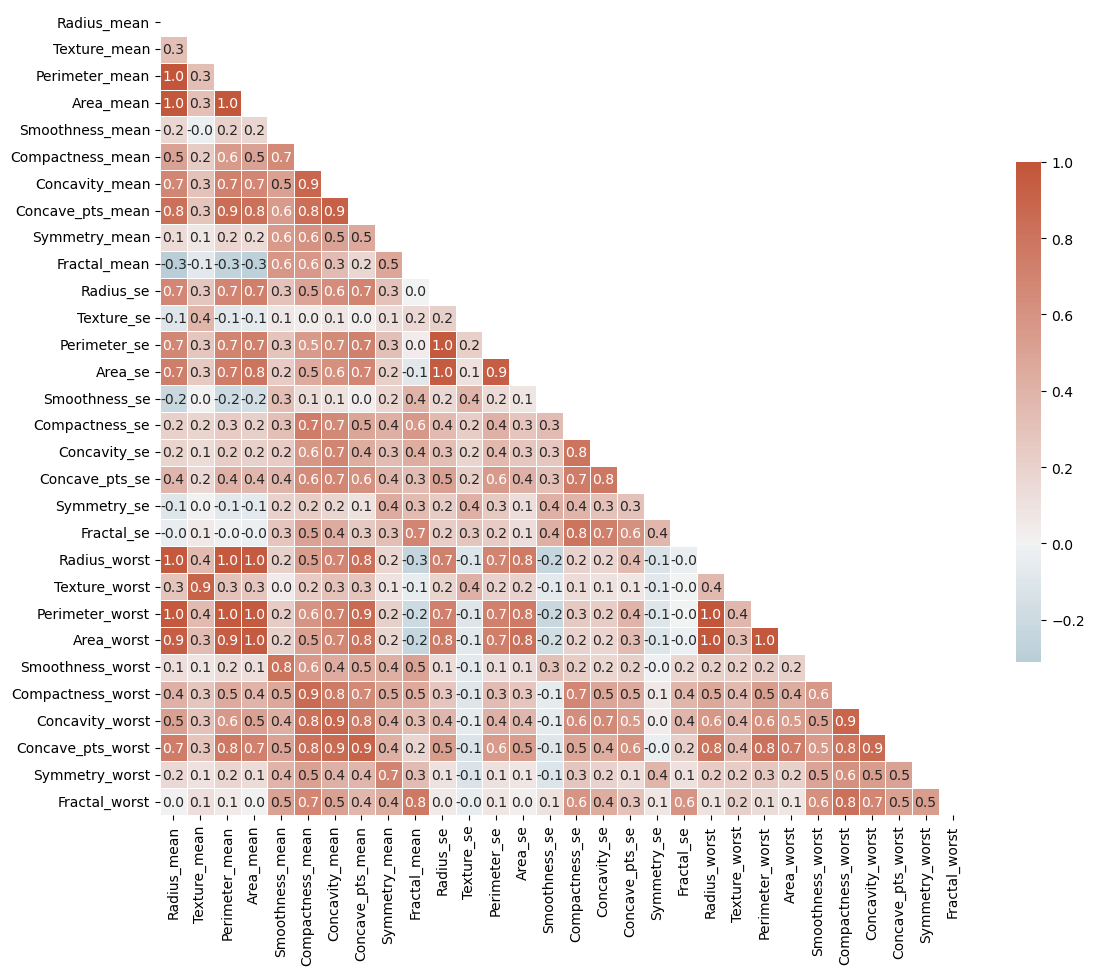

In [20]:
# Correlation matrix
# Compute the correlation matrix
corr = X.corr(numeric_only=False)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13,13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
            fmt='.1f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Briefly summarizing the exploratory data analysis:  

In the exploratory data analysis section of this project, we initially loaded the dataset into pandas DataFrames, carefully separating the features from the target variable, which categorizes the tumors as either benign or malignant. To ensure the data was loaded correctly and formatted as expected, we employed the pandas' info and tail methods. These steps confirmed the dataset's structure and allowed us to identify and subsequently drop the ID column, which is irrelevant to our model's predictive tasks.

A preliminary examination of the dataset was conducted using the pandas describe method. This exploration revealed the necessity of standardizing the features to have a mean of zero and a standard deviation of one, a crucial step for algorithms like PCA and K-means that are sensitive to the scale of the data. Standardization ensures that each feature contributes equally to the analysis, preventing any single feature with a large scale from dominating the model's behavior.

We also analyzed the distribution of the target variable, finding a relatively balanced split between benign (357) and malignant (212) samples. This balance is advantageous for training machine learning models, as it helps avoid biases toward a particular class, ensuring the model learns to accurately identify both conditions without preference.

Finally, the creation of a correlation matrix for all 30 features highlighted a general trend of correlation among them. This observation is particularly pertinent to our approach, as it suggests that Principal Component Analysis (PCA) can be highly effective. PCA will allow us to reduce dimensionality while retaining the variance in the dataset, by transforming correlated features into a smaller number of uncorrelated components. This step is critical for enhancing model performance and interpretability, enabling us to proceed with unsupervised learning methods like K-means clustering on a simplified, yet informative, feature space.


<h3>Model Building / Model Training</h3>
In this section of our analysis, we start model building and training, employing a structured approach to understanding and categorizing breast cancer tumors from fine needle aspirations. The methodology comprises preprocessing and model training steps designed to increase the accuracy of the results.<br><br>

<b>Preprocessing Step:</b> Our first step involves standardizing the features using the StandardScaler function from scikit-learn. This process is vital for aligning all features to the same scale, thereby removing any bias that could result from the variance in magnitudes across features. Standardization is particularly important in our context because algorithms like PCA and K-means clustering are sensitive to the scale of the data, and failing to standardize can lead to misleading interpretations and model performance that does not accurately reflect the underlying patterns in the data.

<b>Principal Component Analysis (PCA):</b> Following standardization, we will perform PCA on the dataset. The importance of PCA lies in its ability to reduce the dimensionality of our dataset while retaining as much of the variation in the data as possible. By selecting a limited number of principal components, we can simplify our dataset, making it more manageable for analysis, without significant loss of information. This step not only helps in reducing computational complexity but also aids in identifying the most influential features that contribute to the variation in the dataset.

<b>K-means Clustering on PCA Components:</b> After identifying the principal components, we will train a K-means clustering model on these selected components. This approach allows us to explore the data's structure and categorize the samples into clusters that potentially correspond to benign and malignant tumors, based on the transformed features that capture the most significant variance within the data.

<b>K-means Clustering on Original Features:</b> To understand the impact of PCA ans standardization on our clustering efforts, we will also train a K-means clustering model directly on the original features. This enables us to assess the effectiveness of dimensionality reduction standardization in improving the model's ability to discern between benign and malignant samples.

<b>Comparison of Model Accuracy:</b> We end our model training phase by comparing the accuracy of the K-means models trained on PCA components versus the original features. By evaluating how each model performs in grouping the samples into benign and malignant categories, against the provided labels, we may show the benefits of PCA in preprocessing data for clustering tasks.



In [21]:
# Preprocessing: Standardize the data features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)


In [22]:
# PCA: Perform PCA on the standardized features
pca = PCA()
pca.fit(X_std)

PCA()

In [23]:
# This shows how much variance is explained by each of the principal components
pca.explained_variance_ratio_

array([4.42720256e-01, 1.89711820e-01, 9.39316326e-02, 6.60213492e-02,
       5.49576849e-02, 4.02452204e-02, 2.25073371e-02, 1.58872380e-02,
       1.38964937e-02, 1.16897819e-02, 9.79718988e-03, 8.70537901e-03,
       8.04524987e-03, 5.23365745e-03, 3.13783217e-03, 2.66209337e-03,
       1.97996793e-03, 1.75395945e-03, 1.64925306e-03, 1.03864675e-03,
       9.99096464e-04, 9.14646751e-04, 8.11361259e-04, 6.01833567e-04,
       5.16042379e-04, 2.72587995e-04, 2.30015463e-04, 5.29779290e-05,
       2.49601032e-05, 4.43482743e-06])

Text(0, 0.5, 'Cumulative Explained Variance')

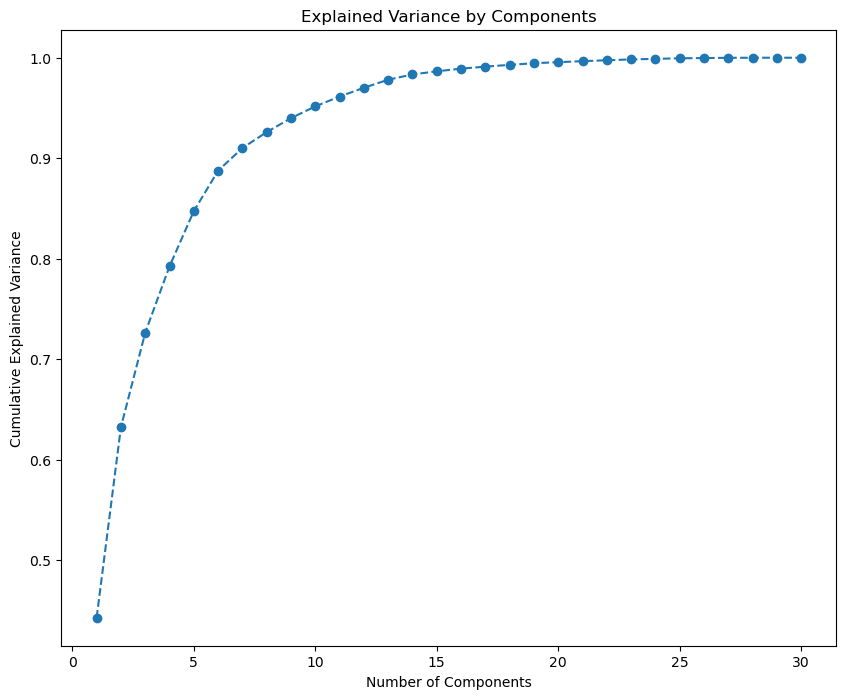

In [24]:
# Here I graph the cummulative sum of the explained variance
plt.figure(figsize=(10,8))
plt.plot(range(1,31), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')


From the above graph we see that the top five principal components explain about 85% of the variance in the data. We will use these five components as to reduce the dimensionality of the dataset. Training on a reduced number of components helps in mitigating the risk of overfitting. Overfitting occurs when a model learns the detail and noise in the training data to the extent that it performs poorly on new data. By concentrating on the principal components, the model is less likely to get influenced by the noise and more likely to generalize well to unseen data.

In [25]:
# The 5 most important components explain about 85% of the variance
pca = PCA(n_components=5)
pca.fit(X_std)

PCA(n_components=5)

In [26]:
# Extract component scores for the elements in our data set
scores_pca = pca.transform(X_std)
print(scores_pca)

[[ 9.19283683  1.94858307 -1.12316617  3.63373089 -1.19511016]
 [ 2.3878018  -3.76817174 -0.52929269  1.11826382  0.62177509]
 [ 5.73389628 -1.0751738  -0.55174759  0.91208272 -0.17708601]
 ...
 [ 1.25617928 -1.90229671  0.56273052 -2.08922703  1.80999135]
 [10.37479406  1.67201011 -1.87702933 -2.35603112 -0.03374195]
 [-5.4752433  -0.67063679  1.49044309 -2.2991571  -0.18470347]]


We conducted an iterative approach to K-means clustering by varying the hyperparameter that specifies the number of clusters (k) from 1 to 20. This systematic exploration was designed to identify the optimal number of clusters that best represents the underlying structure of our dataset. As part of this process, we calculated and graphed the Within-Cluster Sum of Squares (WCSS) for each value of k.

WCSS is a measure used to evaluate the performance of a clustering algorithm, quantifying the variance within each cluster. Specifically, it calculates the sum of the squared distances between each point in a cluster and the centroid of that cluster. A lower WCSS value indicates that the points within each cluster are closer to their centroids, suggesting a better cluster cohesion.

In [27]:
# K-means clustering with PCA
# We will use the transformed data from the PCA
# Test 1-20 clusters
wcss = []
for i in range(1,21):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=1)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

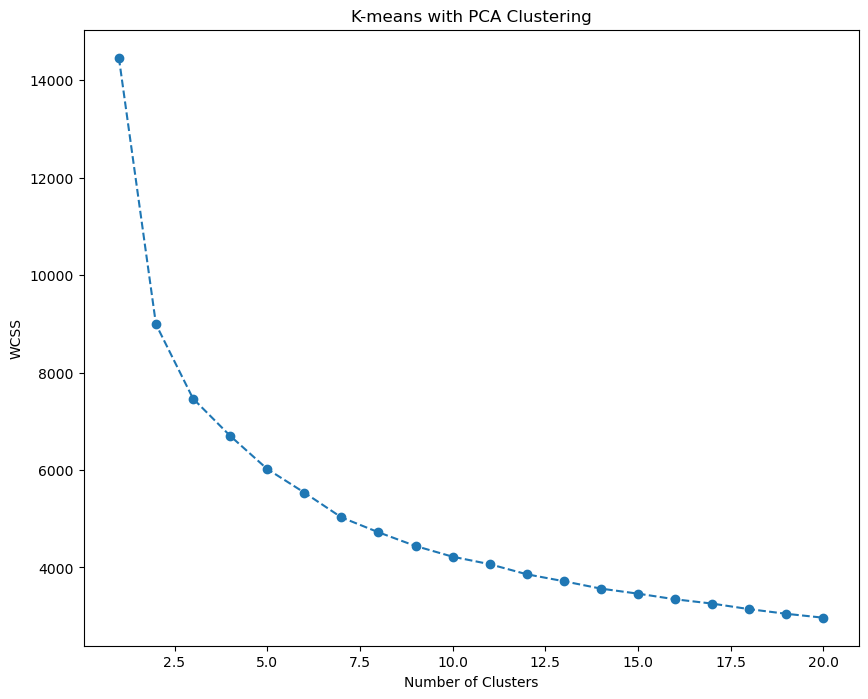

In [28]:
# Plot wcss vs the number of clusters
plt.figure(figsize=(10,8))
plt.plot(range(1,21),wcss,marker='o',linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

To determine the optimal number of clusters, we employed the elbow method, a visual technique based on the WCSS graph. As we increase the number of clusters, the WCSS decreases because the clusters become more specific and closer to the individual data points. However, after a certain point, the reduction in WCSS becomes marginal, indicating that adding more clusters does not significantly improve the fit of the model. This point, where the rate of decrease sharply changes, resembles an 'elbow' on the graph.

Upon examining the WCSS graph, we identified that the elbow point occurs at two clusters. This observation led us to select two clusters as the best setting for our K-means model. Choosing two clusters as the optimal number suggests that our dataset naturally segments into two distinct groups, aligning well with our initial aim to differentiate between benign and malignant samples. This decision is crucial for ensuring that our model is neither over-simplified nor overly complex, balancing the need for interpretability and accuracy in our clustering results.

In [29]:
# Set Kmean_pca to the model with 2 clusters
kmeans_pca = KMeans(n_clusters=2,init='k-means++',random_state=1)
kmeans_pca.fit(scores_pca)


KMeans(n_clusters=2, random_state=1)

In [60]:
# Create a new df with PCA scores and cluster labels
X_pca_kmeans = pd.concat([X.reset_index(drop=True), pd.DataFrame(scores_pca)],axis=1)
X_pca_kmeans.columns.values[-5: ] = ['Component 1','Component 2','Component 3','Component 4','Component 5']
# Add the cluster labels
X_pca_kmeans['Cluster Label'] = kmeans_pca.labels_
# X_pca_kmeans.head()

<AxesSubplot: title={'center': 'PCA scatter of Component 1 vs Component 2'}, xlabel='Component 2', ylabel='Component 1'>

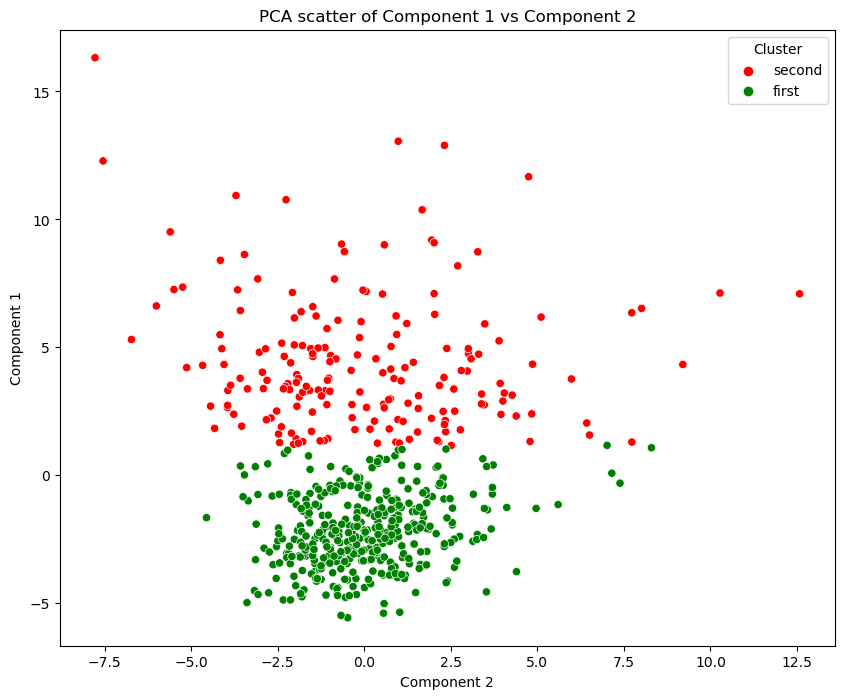

In [31]:
# Plot the data by PCA components. Y axis is first component, X axis is second
X_pca_kmeans['Cluster'] = X_pca_kmeans['Cluster Label'].map({0:'first',1:'second'})
x_axis = X_pca_kmeans['Component 2']
y_axis = X_pca_kmeans['Component 1']
plt.figure(figsize=(10,8))
plt.title('PCA scatter of Component 1 vs Component 2')
sns.scatterplot(x=x_axis,y=y_axis,hue=X_pca_kmeans['Cluster'],palette=['r','g'])

Upon visualizing the data through a graph that plots Principal Component 2 (PC2) against Principal Component 1 (PC1), observe that the samples appear to naturally separate into two distinct clusters with minimal overlap. This graphical representation underscores the efficacy of Principal Component Analysis (PCA) in reducing the dataset to its most informative dimensions.  This suggests that the unsupervised learning algorithm may have separated out the benign and malignant nodules without needing to train on labeled data.  This is tested below by calculating accuracy, recall, precision, and f1.

In [32]:
# Calculate accuracy, recall, precision
accuracy_pca = accuracy_score(y,kmeans_pca.labels_)
recall_pca = recall_score(y,kmeans_pca.labels_)
precision_pca = precision_score(y,kmeans_pca.labels_)
f1_pca = f1_score(y,kmeans_pca.labels_)
print("Accuracy: ", accuracy_pca)
print("Recall: ", recall_pca)
print("Precision: ", precision_pca)
print("f1: ", f1_pca)


Accuracy:  0.9103690685413005
Recall:  0.8254716981132075
Precision:  0.9259259259259259
f1:  0.8728179551122194


From the above calculations, we see that the algorithm performed fairly well. Accuracy, a measure of the true results among the total number of samples tested is relatively high at 91%.  Recall, a measure of actual positives correctly identified, performs slightly worse at 82%.  Precision, a measure of true positives among all positives identified, performs nicely at 93%.  The f1 score takes into account both precision and recall and yields 87%.

We now run the K-means algorithm on the original data without standardization and principal component analysis.  I chose to graph fractal mean versus radius mean as these were relatively uncorrelated (this can be seen in the correlation matrix above).

<AxesSubplot: title={'center': 'Scatter of Fractal Mean vs. Radius Mean'}, xlabel='Radius_mean', ylabel='Fractal_mean'>

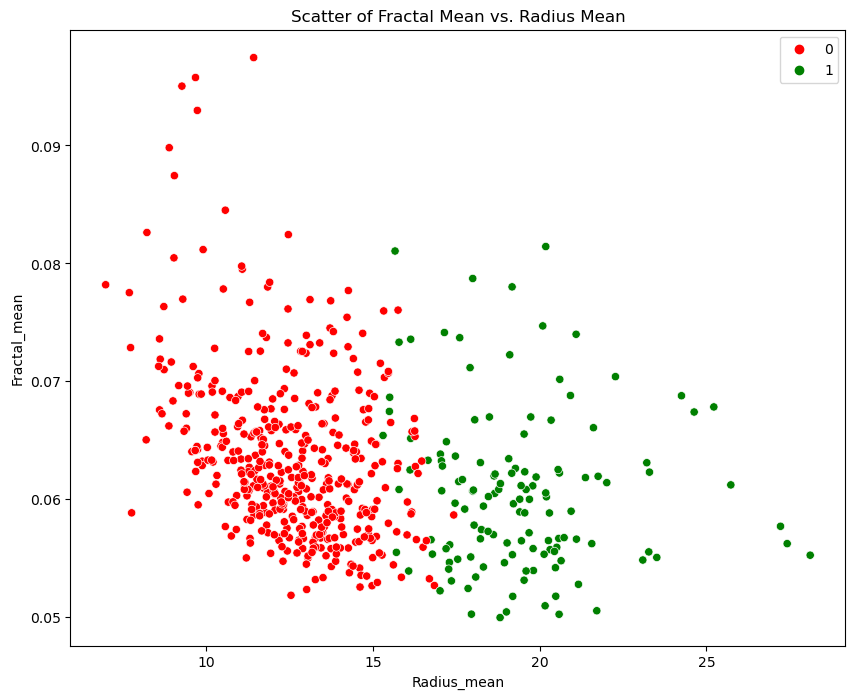

In [61]:
# If we run the k-means without the PCA
# Scatter plot of Radius mean and fractal mean
kmeans_X = KMeans(n_clusters=2,init='k-means++',random_state=1)
kmeans_X.fit(X)
kmeans_X_clusters = kmeans_X.labels_

x_axis = X['Radius_mean']
y_axis = X['Fractal_mean']
plt.figure(figsize=(10,8))
plt.title('Scatter of Fractal Mean vs. Radius Mean')
# sns.scatterplot(x=x_axis,y=y_axis,hue=X_pca_kmeans['Cluster'],palette=['r','g'])
sns.scatterplot(x=x_axis,y=y_axis,hue=kmeans_X_clusters,palette=['r','g'])


In [57]:
# Calculate accuracy, recall, precision
accuracy_X = accuracy_score(y,kmeans_X.labels_)
recall_X = recall_score(y,kmeans_X.labels_)
precision_X = precision_score(y,kmeans_X.labels_)
f1_X = f1_score(y,kmeans_X.labels_)
print("Accuracy: ", accuracy_X)
print("Recall: ", recall_X)
print("Precision: ", precision_X)
print("f1: ", f1_X)

Accuracy:  0.8541300527240774
Recall:  0.6132075471698113
Precision:  0.9923664122137404
f1:  0.7580174927113702


From the above scatter plot we see that the two clusters are slightly more mixed and that the accuracy scores are not quite as good.  Interestingly, precision did see a large jump to 99% while recall fell to 61%.  This seems to indicate that the model is under-calling malignant nodules, but when it calls malignant nodules it is usually correct.

<h3>Results and Analysis</h3>

In our investigation into the differentiation of benign and malignant breast cancer samples using unsupervised machine learning techniques, we executed several key steps to preprocess the data, reduce its dimensionality, and apply clustering algorithms. This systematic approach allowed us to analyze and compare the efficacy of different models in categorizing the samples based on their features.

Preprocessing with StandardScaler: Our initial step involved standardizing the dataset using the StandardScaler function from scikit-learn. This preprocessing stage ensured that all features contributed equally to the analysis, eliminating biases that could arise from the varying scales of the data. Standardization is essential for algorithms like PCA and K-means clustering, which are sensitive to the scale of the features, to perform optimally.

Principal Component Analysis: We then applied Principal Component Analysis (PCA) to reduce the dimensionality of our data, selecting the top 5 components which together accounted for approximately 85% of the total variation within the dataset. This step was crucial for simplifying the dataset while retaining the most significant information, thereby reducing model complexity.

K-means Clustering (Iterated 1-20 Clusters): With the dimensionality reduced, we employed K-means clustering, iterating the number of clusters from 1 to 20. This iterative process, coupled with the evaluation of the Within-Cluster Sum of Squares (WCSS), allowed us to apply the elbow method to identify the optimal number of clusters. We found that two clusters were the most appropriate setting, which aligned well with our objective to differentiate between benign and malignant samples.

K-means Clustering on Original Features: To assess the impact of PCA on the clustering process, we also conducted K-means clustering directly on the original features. This comparative analysis aimed to evaluate the benefits of dimensionality reduction in enhancing the model's performance.

Comparison of Model Accuracy: The culmination of our study involved comparing the accuracy of the K-means models trained on the PCA components versus the original features. Our findings revealed that clustering on PCA components performed significantly better, indicating that the dimensionality reduction through PCA not only facilitated a more streamlined analysis but also led to more accurate categorization of the samples.

| Model                          | Accuracy | Recall | Precision | f1     |
|--------------------------------|----------|--------|-----------|--------|
| K-means (standardized and PCA) | 0.9103   | 0.8255 | 0.9259    | 0.8728 |
| K-means (original features)    | 0.8541   | 0.6132 | 0.9924    | 0.7580 |
|                                |          |        |           |        |

This superior performance can be attributed to PCA's ability to condense the dataset to its most informative features, thereby enhancing the K-means algorithm's capacity to detect the inherent patterns in the data. The clear separation of samples into two distinct clusters, as observed in the PCA components' graphical representation, further validated the effectiveness of this approach.






<h4>Conclusion</h4>

The project showed that machine learning, especially techniques like preprocessing, PCA, and K-means clustering, can effectively differentiate between benign and malignant breast cancer samples even without labeled data. Yet, there's more that could be done to refine our understanding and classification of these samples.

Using more clusters should be considered. This approach might help us identify not just whether tumors are benign or malignant but also more specific conditions like precancerous states in benign tumors or various stages and grades in malignant tumors.  This could help in determining how agressively to treat the cancer. However, this would need more detailed patient data to ensure accuracy and relevance.

Additionally, it would be interesting to test other types of unsupervised learning, such as hierarchical clustering. This method doesn't just split data into predefined clusters but shows how all the data points are related to each other, possibly offering new insights into the nature of different tumors and how they progress.

In summary, the results and analysis underscore the value of combining preprocessing techniques like StandardScaler and dimensionality reduction methods such as PCA with clustering algorithms like K-means to improve the accuracy and efficiency of machine learning models, especially in the context of medical diagnostics. This project not only demonstrates a practical application of these techniques but also highlights the potential for machine learning to contribute significantly to advancements in healthcare and disease detection.
